In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import common
import DataProcessing as dp
from scipy import stats
import seaborn as sns
from prettytable import PrettyTable

In [41]:
flip0,b = common.readAllAcqs('E:/JiaxingData/EMINoise/1209/AMSineFA0_1.h5')
flip0 = dp.ConvergeComplexR(dp.SplitComplexR(flip0))

def PCCCalculation(sig1,sig2):
    if(sig1.ndim != sig2.ndim):
        print("signal 1 and signal 2 have different dimensions")
    elif(sig1.ndim == 1):
        real_corr, _ = stats.pearsonr(np.real(sig1), np.real(sig2))
        imag_corr, _ = stats.pearsonr(np.imag(sig1), np.imag(sig2))
    else:
        real_corr = np.zeros((sig1.shape[1]))
        imag_corr = np.zeros((sig1.shape[1]))
        for i in range(0, sig1.shape[1]):
            real_corr[i],_ = stats.pearsonr(np.real(sig1[i]), np.real(sig2[i]))
            imag_corr[i], _ = stats.pearsonr(np.imag(sig1[i]), np.imag(sig2[i]))
    return real_corr, imag_corr

sig = flip0

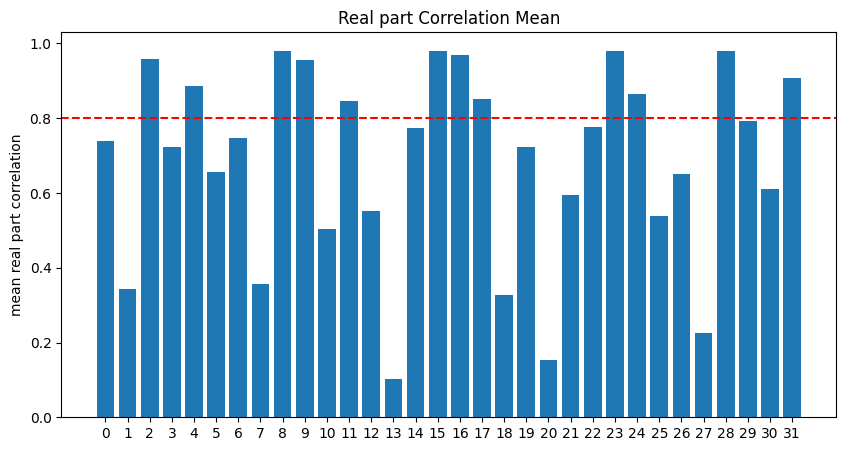

[0, 0, 512, 0, 0, 0, 0, 0, 0, 512, 0, 512, 0, 0, 0, 0, 0, 512, 0, 0, 0, 0, 7, 0, 512, 0, 0, 0, 0, 197, 0, 512]
[0, 0, 512, 0, 0, 0, 0, 0, 0, 512, 0, 512, 0, 0, 0, 0, 0, 512, 0, 0, 0, 0, 4, 0, 512, 0, 0, 0, 0, 191, 0, 512]


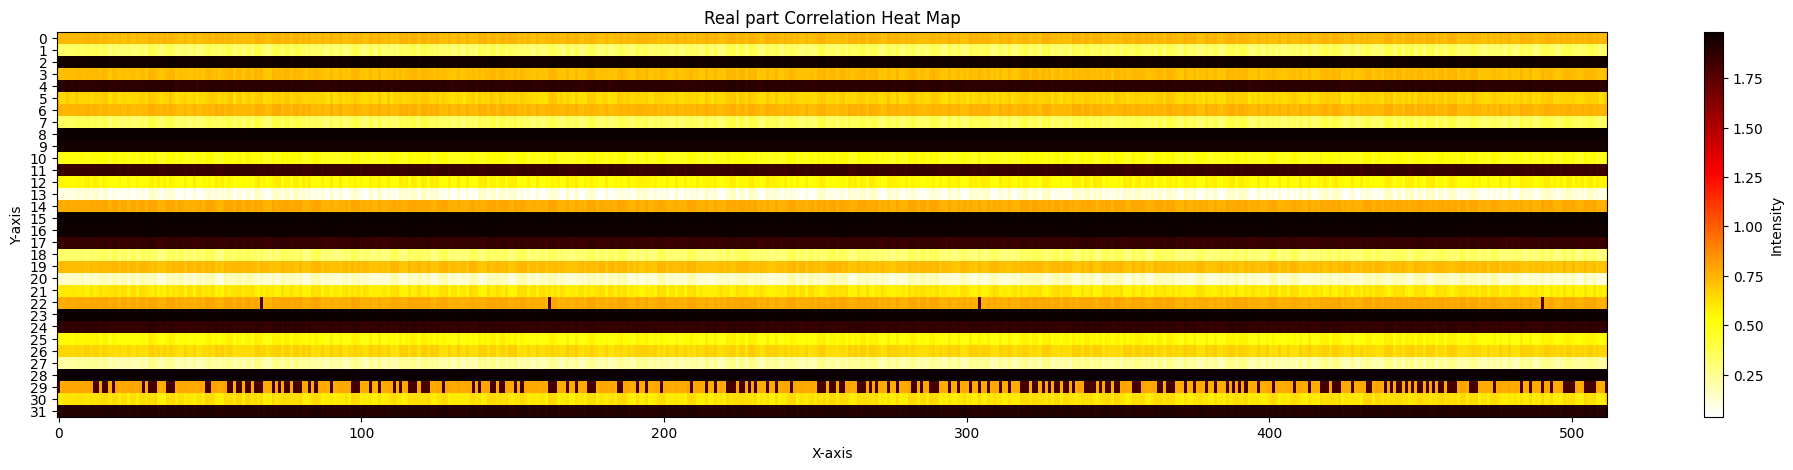

In [42]:

real_corr = []
imag_corr = []
for i in range(0,16):
    for k in range(16,18):
        real_corr_temp,imag_corr_temp = PCCCalculation(sig[:,i],sig[:,k])
        real_corr.append(real_corr_temp)
        imag_corr.append(imag_corr_temp)
mean_real_corr = np.mean(np.abs(real_corr),axis = 1)
mean_imag_corr = np.mean(np.abs(imag_corr),axis = 1)
plt.figure(figsize=(10,5))
plt.bar(range(32),mean_real_corr)
plt.ylabel('mean real part correlation')
plt.axhline(y=0.8, color='red', linestyle='--', label='y = 0.8')
plt.xticks(range(0, 32, 1))
plt.title('Real part Correlation Mean')
plt.show()

count_strong_real_corr = []
count_strong_imag_corr = []
for i in range(0,32):
    strong_real_corr = (real_corr[i] > 0.8)
    strong_imag_corr = (imag_corr[i] > 0.8)
    count_strong_real_corr.append(strong_real_corr.sum())
    count_strong_imag_corr.append(strong_imag_corr.sum())
    
print(count_strong_real_corr)
print(count_strong_imag_corr)
imag_corr = np.array(np.abs(imag_corr))
imag_corr[imag_corr >= 0.8] += 1
#heat plot
plt.figure(figsize=(25,5))
plt.imshow(imag_corr,aspect='auto',cmap='hot_r',interpolation='none')
plt.colorbar(label='Intensity')  # Add a color bar
plt.title("Real part Correlation Heat Map")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.yticks(range(0, 32, 1))
plt.show()

In [5]:
def frequencyBandDivision(sig, fd, bands):
    fft = np.abs(np.fft.fft(sig))
    sampling_frequency = common.getRate(fd)
    freqs = np.fft.fftfreq(len(sig),1/sampling_frequency)
    band_mask1 = (freqs >= bands[0,0]) & (freqs < bands[0,1])
    fft1 = fft * band_mask1
    band_mask2 = (freqs >= bands[1,0]) & (freqs < bands[1,1])
    fft2 = fft * band_mask2
    band_mask3 = (freqs >= bands[2,0]) & (freqs < bands[2,1])
    fft3 = fft * band_mask3
    return fft1,fft2,fft3

def TFCalculation(sig,fd,bands,channel=18):
    fft1 = []
    fft2 = []
    fft3 = []
    for i in range(0,18):
        fft1_temp,fft2_temp,fft3_temp = frequencyBandDivision(sig,fd,bands)
        fft1.append(fft1_temp)
        fft2.append(fft2_temp)
        fft3.append(fft3_temp)
    MRISignal1 = fft1[0:16]
    MRISignal2 = fft2[0:16]
    MRISignal3 = fft3[0:16]
    if channel == 18:
        EMISignal1 = fft1[16:18]
        EMISignal2 = fft2[16:18]
        EMISignal3 = fft3[16:18]
    else:
        EMISignal1 = fft1[channel]
        EMISignal2 = fft2[channel]
        EMISignal3 = fft3[channel]
    tf1 = np.zeros((16,2),dtype= np.complex64)
    tf1 = np.dot(MRISignal1,np.linalg.pinv(EMISignal1.reshape(1,len(EMISignal1))))
    tf2 = np.zeros((16,2),dtype= np.complex64)
    tf2 = np.dot(MRISignal2,np.linalg.pinv(EMISignal2.reshape(1,len(EMISignal1))))
    tf3 = np.zeros((16,2),dtype= np.complex64)
    tf3 = np.dot(MRISignal3,np.linalg.pinv(EMISignal3.reshape(1,len(EMISignal1))))
    return tf1,tf2,tf3


def denoising(sig,fd,bands,channel):
    tf1,tf2,tf3 = TFCalculation(sig[0],fd,bands,channel)

    fft1 = []
    fft2 = []
    fft3 = []
    for i in range(0,18):
        fft1_temp,fft2_temp,fft3_temp = frequencyBandDivision(sig[128],fd,bands)
        fft1.append(fft1_temp)
        fft2.append(fft2_temp)
        fft3.append(fft3_temp)
    MRISignal1 = fft1[0:16]
    MRISignal2 = fft2[0:16]
    MRISignal3 = fft3[0:16]
    if channel == 18:
        EMISignal1 = fft1[16:18]
        EMISignal2 = fft2[16:18]
        EMISignal3 = fft3[16:18]
    else:
        EMISignal1 = fft1[channel]
        EMISignal2 = fft2[channel]
        EMISignal3 = fft3[channel]
    denoised = sig[128,0:16]

    pred1 = np.dot(EMISignal1,tf1)
    pred2 = np.dot(EMISignal2,tf2)
    pred3 = np.dot(EMISignal3,tf3)
    pred = np.concatenate((pred1,pred2,pred3),axis=1)
    denoised = denoised - np.fft.ifft(pred)
    return denoised



In [23]:
def TFCalculation2(sig,channel=18):
    MRISignal = sig[0:16]
    if channel == 18:
        EMISignal = sig[16:18]
        tf = np.zeros((16,2),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal))
    else:
        EMISignal = sig[channel]
        tf = np.zeros((16,1),dtype= np.complex64)
        tf = np.dot(MRISignal,np.linalg.pinv(EMISignal.reshape(1,len(EMISignal))))
    return tf

def denoising2(sig,channel1,channel2=18):
    tf = TFCalculation2(sig[0], channel2)
    denoised = sig[channel1,0:16]
    if channel2 == 18:
        EMISignal = sig[channel1,16:18]
        pred = np.dot(tf,EMISignal)
        denoised = denoised - pred
    else:
        EMISignal = sig[channel1,channel2]
        pred = np.dot(tf,EMISignal.reshape(1,512))
        denoised = denoised - pred
    return denoised

In [7]:
def mean(sig):
    return np.mean(sig)

def peak(sig):
     return np.max(sig)

def std(sig):
     return np.std(sig, dtype=np.float64)

# before suppression/ after suppression of channel 16/ suppression rate (SR)/ after channel 17/ suppression rate / after channel 16+17/ suppression rate
# mean
# peak
# standard deviation
# PCC
def experiment1DTable(before,sup16,sup17,supComb):
    meanBefore = mean(before)
    peakBefore = peak(before)
    stdBefore = std(before)
    meanSup16 = mean(sup16)
    peakSup16 = peak(sup16)
    stdSup16 = std(sup16)
    SRMeanSup16 = 1 - (meanSup16/meanBefore)
    SRPeakSup16 = 1 - (peakSup16/peakBefore)
    SRStdSup16 = 1 - (stdSup16/stdBefore)
    meanSup17 = mean(sup17)
    peakSup17 = peak(sup17)
    stdSup17 = std(sup17)
    SRMeanSup17 = 1 - (meanSup17/meanBefore)
    SRPeakSup17 = 1 - (peakSup17/peakBefore)
    SRStdSup17 = 1 - (stdSup17/stdBefore)
    meanSupComb = mean(supComb)
    peakSupComb = peak(supComb)
    stdSupComb = std(supComb)
    SRMeanSupComb = 1 - (meanSupComb/meanBefore)
    SRPeakSupComb = 1 - (peakSupComb/peakBefore)
    SRStdSupComb = 1 - (stdSupComb/stdBefore)
    table = PrettyTable(["","Before suppression", "After suppression with Channel 16",
                          "Suppression Rate1", "After suppression with Channel 17",
                          "Suppression Rate2","After suppression with Channel 16 and 17",
                          "Suppression Rate3"])
    table.add_row(["mean",meanBefore,meanSup16,SRMeanSup16,meanSup17,SRMeanSup17,meanSupComb,SRMeanSupComb]) 
    table.add_row(["peak",peakBefore,peakSup16,SRPeakSup16,peakSup17,SRPeakSup17,peakSupComb,SRPeakSupComb]) 
    table.add_row(["standard deviation",stdBefore,stdSup16,SRStdSup16,stdSup17,SRStdSup17,stdSupComb,SRStdSupComb]) 
    print(table)

In [25]:
#fd = 'E:/JiaxingData/EMINoise/1209/AMSquareFA0_1.h5'
#bands = np.array([[0,5000],[5000,15000],[15000,32000]])
channel1 = 500
sup16 = denoising2(sig,channel1,16)
sup17 = denoising2(sig,channel1,17)
supcomb = denoising2(sig,channel1,18)

experiment1DTable(np.abs(sig[channel1,0:16]),np.abs(sup16),np.abs(sup17),np.abs(supcomb))


+--------------------+--------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|                    | Before suppression | After suppression with Channel 16 | Suppression Rate1  | After suppression with Channel 17 | Suppression Rate2  | After suppression with Channel 16 and 17 | Suppression Rate3  |
+--------------------+--------------------+-----------------------------------+--------------------+-----------------------------------+--------------------+------------------------------------------+--------------------+
|        mean        |     107.31865      |              7.996896             | 0.9254845678806305 |             4.7439857             | 0.9557953290641308 |                4.6730638                 | 0.9564561806619167 |
|        peak        |      585.7816      |              80.52974             | 0.862525999546051  |            

In [111]:
result = stats.kstest(np.imag(sig[511,15]), 'norm') # Test if the sample follows a standard normal distribution
print("Statistic:", result.statistic)
print("P-value:", result.pvalue)

Statistic: 0.5719850930441877
P-value: 4.959634742091464e-159
